In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from skimage.draw import line
from tqdm import tqdm

In [20]:
# === CONFIGURAÇÕES ===
IMAGE_PATH = "plant.png"
FREQ_GHZ = 5.0
TX_POWER_DBM = 20
NOISE_FLOOR_DBM = -100
PATH_LOSS_EXPONENT = 3.0  # Fator de perda de caminho (2.0 para espaço livre, >2 para ambientes internos)
METERS_PER_PIXEL = 0.005   # Escala: 1 pixel = 10cm. AJUSTE ESTE VALOR para a sua planta.
WALL_ATTENUATION_DB = 5.0 # Perda em dB para cada parede atravessada

# === PONTO DE ORIGEM (forçado manualmente, se necessário) ===
USE_MANUAL_ORIGIN = False
MANUAL_ORIGIN = (300, 280)  # (x, y) estimado visualmente

In [21]:

# === FUNÇÃO PARA ENCONTRAR PONTO PRETO ===
def find_origin(image, target_color=(0, 0, 0)):
    mask = cv2.inRange(image, np.array(target_color), np.array(target_color))
    coords = cv2.findNonZero(mask)
    if coords is not None:
        return tuple(coords[0][0])  # (x, y)
    return None

# === VERIFICA SE CAMINHO TEM BLOQUEIO ===
def is_blocked(img, origin, target):
    rr, cc = line(origin[1], origin[0], target[1], target[0])
    # Itera sobre a linha de visão, pulando o primeiro pixel (a própria origem)
    for i in range(1, len(rr)):
        y, x = rr[i], cc[i]
        if np.all(img[y, x] == 0):
            return True
    return False

In [22]:

# === CONTA QUANTAS PAREDES HÁ NO CAMINHO ===
def count_walls_on_path(img, origin, target):
    """Conta quantas paredes (pixels pretos) existem na linha de visão."""
    rr, cc = line(origin[1], origin[0], target[1], target[0])
    wall_crossings = 0
    # Para evitar contar a mesma parede grossa múltiplas vezes,
    # rastreamos se estamos atualmente 'dentro' de uma parede.
    currently_in_wall = False
    # Itera sobre a linha de visão, pulando o primeiro pixel (a própria origem)
    for i in range(1, len(rr)):
        y, x = rr[i], cc[i]
        is_wall = np.all(img[y, x] == 0)
        if is_wall and not currently_in_wall:
            wall_crossings += 1
            currently_in_wall = True
        elif not is_wall:
            currently_in_wall = False
    return wall_crossings

In [23]:
# === GERA O HEATMAP DE POTÊNCIA ===
def compute_signal_strength_map(image, origin, tx_power_dbm, path_loss_exp, freq_ghz):
    height, width = image.shape[:2]
    heatmap = np.full((height, width), NOISE_FLOOR_DBM, dtype=np.float32)

    freq_hz = freq_ghz * 1e9
    c = 3e8
    lambda_m = c / freq_hz
    # Constante de perda de caminho em espaço livre para uma distância de referência de 1 metro
    fspl_at_1m = 20 * np.log10(4 * np.pi / lambda_m)

    # Adiciona a barra de progresso ao loop principal
    for y in tqdm(range(height), desc="Calculando Heatmap"):
        for x in range(width):
            # Não calcula o sinal para paredes, exceto para o ponto de origem
            if np.all(image[y, x] == 0) and (x, y) != origin:
                continue

            # Conta o número de paredes no caminho e calcula a atenuação
            num_walls = count_walls_on_path(image, origin, (x, y))
            wall_attenuation = num_walls * WALL_ATTENUATION_DB

            # Calcula a distância em metros usando a escala definida
            distance_in_meters = np.hypot(x - origin[0], y - origin[1]) * METERS_PER_PIXEL
            
            # Se a distância for zero (no ponto de origem), a potência recebida é a transmitida.
            # Caso contrário, calcula-se a perda de sinal.
            if distance_in_meters == 0:
                rx_power = tx_power_dbm
            else:
                # Modelo de perda de caminho log-distance
                path_loss = fspl_at_1m + 10 * path_loss_exp * np.log10(distance_in_meters)
                # A potência recebida é a potência transmitida menos a perda de caminho e a atenuação das paredes
                rx_power = tx_power_dbm - path_loss - wall_attenuation
            
            heatmap[y, x] = max(NOISE_FLOOR_DBM, rx_power)

    return heatmap

In [24]:
# === MAIN ===
img = cv2.imread(IMAGE_PATH)
if img is None:
    raise FileNotFoundError(f"Imagem não encontrada: {IMAGE_PATH}")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Define a origem como o centro da imagem
height, width, _ = img_rgb.shape
origin = (width // 2, height // 2)

heatmap = compute_signal_strength_map(img_rgb, origin, TX_POWER_DBM, PATH_LOSS_EXPONENT, FREQ_GHZ)


Calculando Heatmap:   0%|          | 0/546 [00:00<?, ?it/s]

Calculando Heatmap: 100%|██████████| 546/546 [07:40<00:00,  1.19it/s]


In [25]:
# === EXIBIÇÃO COM BARRA DE CORES E MARCAÇÃO DO PONTO ===
def show_heatmap_overlay(image, heatmap, origin, vmin=-100, vmax=0, alpha=0.5, save_path=None):
    norm = Normalize(vmin=vmin, vmax=vmax)
    norm_heatmap = norm(heatmap)

    cmap = plt.get_cmap('jet')
    color_map = cmap(norm_heatmap)[:, :, :3]
    color_map = (color_map * 255).astype(np.uint8)
    overlay = cv2.addWeighted(image, 1 - alpha, color_map, alpha, 0)

    # Destaca o ponto de origem com um círculo vermelho
    cv2.circle(overlay, origin, radius=5, color=(255, 0, 0), thickness=-1)

    fig, ax = plt.subplots(figsize=(16, 9))
    im = ax.imshow(overlay)
    ax.axis("off")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()



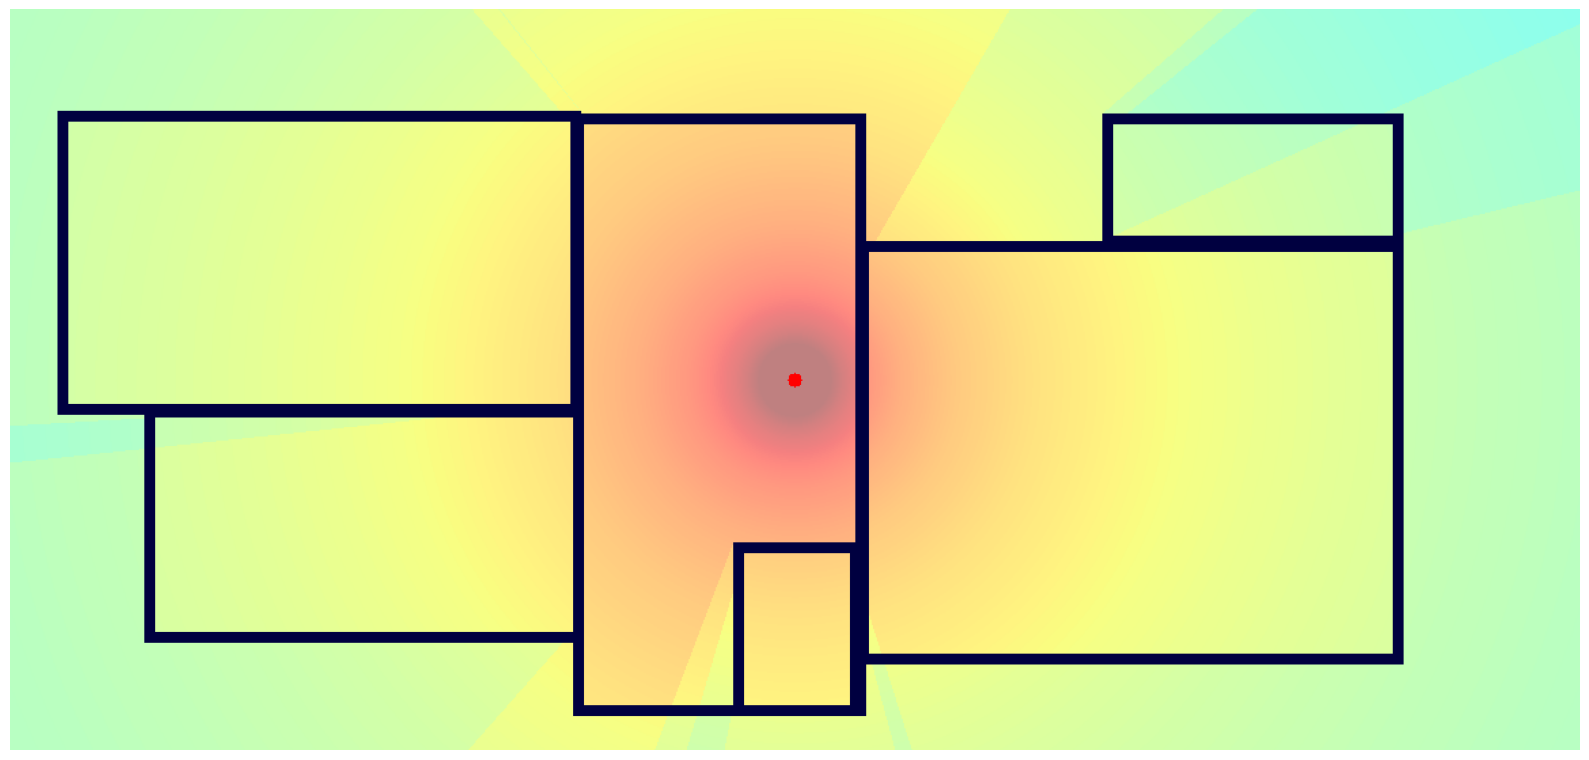

In [26]:
show_heatmap_overlay(img_rgb, heatmap, origin, save_path="./out/heatmap_overlay.png")
